# Part 6: Basic Panoramic Image

### For this part and the next part, you can use any set of images (even images taken by yourself) that support your implementation. You must include the images in your submission.

### 1.Using SIFT and RANSAC for computing the homography matrices, create a program to generate panoramic images given ordered images. Using as many provided images as you can, show the output of your panoramic image.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import random as rm
import math
import cv2
from tkinter import *
from tkinter import messagebox
from PIL import Image, ImageTk
import random

In [3]:
# import the image
im1 = cv2.imread('im01.jpg',cv2.IMREAD_COLOR)
im2 = cv2.imread('im02.jpg',cv2.IMREAD_COLOR)
im3 = cv2.imread('im03.jpg',cv2.IMREAD_COLOR)
im4 = cv2.imread('im04.jpg',cv2.IMREAD_COLOR)
im5 = cv2.imread('im05.jpg',cv2.IMREAD_COLOR)
img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(im4, cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(im5, cv2.COLOR_BGR2RGB)

In [4]:
# show input image
input_images=np.hstack((im1,im2,im3,im4))
cv2.imshow('Input Images',input_images)
cv2.waitKey(0)
cv2.destroyWindow('Input Images')
cv2.waitKey(1)

-1

In [5]:
# mini square
def mini_square(des1,des2):
    [p1,n] = des1.shape
    [p2,n] = des2.shape
    
    # find mini distance position
    # return the matches relationship of both sides
    matches1 = []
    for j in range(0,p1):
        dis = np.zeros([p2,1])
        for k in range(0,p2):
            v = des1[j]-des2[k]
            dis[k] = np.dot(v,v.T)
            
        # find the mini position
        pos = np.argmin(dis)
        # _distance should not be float
        tmp = int(dis[pos])
        
        # store the position in DMatch
        matches1.append(cv2.DMatch(_distance=tmp,_queryIdx=j,_trainIdx=pos,_imgIdx=0))

    matches2 = []
    for j in range(0,p2):
        dis = np.zeros([p1,1])
        for k in range(0,p1):
            v = des2[j]-des1[k]
            dis[k] = np.dot(v,v.T)
            
        # find the mini position
        pos = np.argmin(dis)
        tmp = int(dis[pos])
        
        # store the position in DMatch
        matches2.append(cv2.DMatch(_distance=tmp,_queryIdx=j,_trainIdx=pos,_imgIdx=0))
    
    # matches points that are same in query index and train index
    matches = []
    for i in matches1:
        for j in matches2:
            if i.queryIdx == j.trainIdx and i.trainIdx == j.queryIdx:
                matches.append(i)
    
    return matches
                

In [6]:
# Find SIFT and return Homography Matrix
def SIFT(im1, im2):
    # im1 and im2 are grayscale image

    # Initialize SIFT 
    sift=cv2.SIFT_create() 
    
    # turn to grayscale
    im1 = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

    # Extract keypoints and descriptors
    kp1,des1=sift.detectAndCompute(im1,None)
    kp2,des2=sift.detectAndCompute(im2,None)

    # match the points
    # using DMatch instead of matrix. matrix not so powerful and easily went wrong
    matches = mini_square(des1,des2)
    
#     # Bruteforce matcher on the descriptors
#         another way to match the pairs of points using KNN

#     bruteforce=cv2.BFMatcher()
#     matches=bruteforce.knnMatch(des1,des2, k=2)

#     # Make sure that the matches are good
#     verify_ratio=0.8 
#     verified_matches=[]
#     for m1,m2 in matches:
#         # Add to array only if it's a good match
#         if m1.distance<0.8*m2.distance:
#             #turn DMatch to matrix
#             verified_matches.append([m1.queryIdx,m1.trainIdx])

#     verified_matches = np.matrix(verified_matches)

    # Mimnum number of matches
    min_matches=8
    if len(matches)>min_matches:
        return matches,kp1,kp2
    else:
        print('Error: Not enough matches')
        exit()

In [7]:
# homography computing
def hmat(points):
    row = len(points)
    n_mat = int(row/2)
    A = np.zeros([row,9])
    
    for i in range(0,n_mat):
        h1_x = points[i][0]
        h1_y = points[i][1]
        h2_x = points[i+n_mat][0]
        h2_y = points[i+n_mat][1]
        A[2*i][:] = [h1_x,h1_y,1,0,0,0,-h2_x*h1_x,-h2_x*h1_y,-h2_x]
        A[2*i+1][:] = [0,0,0,h1_x,h1_y,1,-h2_y*h1_x,-h2_y*h1_y,-h2_y]

    _, _, vt = linalg.svd(A)
    H = vt[-1].reshape(3,3)
    H = H / H[2,2] # H(3,3) = 1

    return H

In [8]:
# count inliers
def inlier(H,mp,matches,threshold):
    row = len(mp)
    p1 = mp[:,0:2]
    p2 = mp[:,2:4]
    
    x1 = np.concatenate((p1,np.ones([row,1])),axis = 1)
    # transfer 
    x2 = np.dot(H,x1.T)
    x2 = x2[0:2,:]/x2[2,:]
    es_p2 = x2[0:2,:].T
    
    # distance
    diff = p2 - es_p2
    sq = diff * diff
    dis = np.sqrt(sq[:,0] + sq[:,1])
    
    # calculate the number of points that distance < threshold
    # inliers' position
    match = []
    for i in range(0,row):
        if dis[i] < threshold:
            match.append(matches[i])
    
    return match

In [9]:
# RANSAC + Homography
def homo_ransac(kp1,kp2,matches,repeat):
    # n the pairs of keypoints selected randomly (n >= 4)
    n = 4
    # loop times
    loop = repeat
    # HH the largest inliers H
    HH = []
    # threshold of the inliers distance
    threshold = 1
    # inliers box
    num_in = 0
    
    # change the kp1 and kp2 from tuple to list
    N = len(matches)
    k1 = np.zeros([N,2])
    k2 = np.zeros([N,2])

    # Get the coordinate of keypoint
    for i in range(N):
        for j in range(2):
            k1[i,j] = kp1[matches[i].queryIdx].pt[j]
            k2[i,j] = kp2[matches[i].trainIdx].pt[j]
    
    # matched points
    mp = np.concatenate((k1,k2),axis = 1)
    
    for i in range(0,loop):
        # Use four random pair of keypoints to compute the homography matrix
        rdm = random.sample(range(0,N),4)
        points = np.array([[k1[rdm[0]][0],k1[rdm[0]][1]],[k1[rdm[1]][0],k1[rdm[1]][1]],
                      [k1[rdm[2]][0],k1[rdm[2]][1]],[k1[rdm[3]][0],k1[rdm[3]][1]],
                            [k2[rdm[0]][0],k2[rdm[0]][1]],[k2[rdm[1]][0],k2[rdm[1]][1]],
                      [k2[rdm[2]][0],k2[rdm[2]][1]],[k2[rdm[3]][0],k2[rdm[3]][1]]])
        
        # compute H
        H = hmat(points)
        
        # count inliers
        match = inlier(H,mp,matches,threshold)
        
        # keep the max inliers parameter
        if len(match) > num_in:
            num_in = len(match)
            HH = H
            match_best = match

    return HH,match_best
        

In [10]:
# build a canvas
def get_canvas(im1,im2,Hi):
    # Hi is im2 to im1
    [row1,col1,c] = im1.shape
    [row2,col2,c] = im2.shape

    # get the edge
    [x_max,x_min,y_max,y_min] = get_size(im2,Hi)
    print([x_min,x_max,y_min,y_max])
    x_minus = int(np.min([0,x_min])-10)
    x_plus = int(np.max([0,x_max-row1])+10)
    y_minus = int(np.min([0,y_min])-10)
    y_plus = int(np.max([0,y_max-col1])+10)
    
    # x direction adding space
    add_x_minus = np.zeros([-x_minus,col1,c])
    add_x_plus = np.zeros([x_plus,col1,c])
    
    # y direction adding space
    add_y_minus = np.zeros([-x_minus+row1+x_plus,-y_minus,c])
    add_y_plus = np.zeros([-x_minus+row1+x_plus,y_plus,c])
    
    # concatenate the adding space with im1
    canvas = np.concatenate((add_x_minus,im1,add_x_plus),axis = 0)
    canvas = np.concatenate((add_y_minus,canvas,add_y_plus),axis = 1)
    
    return canvas.astype(int),[x_minus,y_minus]




In [11]:
# transform h1 to h2
def get_size(h1,H):
    [row,col,c] = h1.shape
    
    # 4 cornor of the image h1
    lt = np.array([[0,0,1]])
    rt = np.array([[0,col,1]])
    lb = np.array([[row,0,1]])
    rb = np.array([[row,col,1]])
    
    # edge matrix
    edge = np.concatenate((lt,rt,lb,rb),axis = 0).T
    
    T_edge = np.dot(H,edge)
    # normalize
    T_edge = T_edge[0:2,:]/T_edge[2,:]
    T_edge = T_edge
    
    return np.max(T_edge[0,:]),np.min(T_edge[0,:]),np.max(T_edge[1,:]),np.min(T_edge[1,:])
    

In [12]:
def trans2im1(canvas,im2,Hi,compensation,step):
    # the wight of the im1 when overlay
    w = 0.6
    
    # step of the transmitting 1/step
    [row,col,c] = im2.shape
    
    # draw im2 on the canvas
    for j in range(0,row*step):
        for k in range(0,col*step):
            # positon: points of im2 in im1 plane 
            p = np.array([[j/step,k/step,1]]).T
            Tp = np.dot(Hi,p)

            # normalize and move the image
            x2 = int(round(Tp[0,0]/Tp[2,0])-compensation[0])
            y2 = int(round(Tp[1,0]/Tp[2,0])-compensation[1])
            
            # position in im1
            x1 = int(j/step)
            y1 = int(k/step)

            if np.any(canvas[x2,y2] > 0):
                canvas[x2,y2] = w * canvas[x2,y2][:] + (1 - w) * im2[x1,y1][:]
            else:
                canvas[x2,y2] = im2[x1,y1][:]
    
    return canvas.astype(int)
    

In [13]:
# compute Homography from the inliers
def HHmat(kp1,kp2,match_best):
    # change the inliers from tuple to list
    N = len(match_best)
    in1 = np.zeros([N,2])
    in2 = np.zeros([N,2])

    # Get the coordinate of keypoint
    for i in range(N):
        for j in range(2):
            in1[i] = [kp1[match_best[i].queryIdx].pt[1],kp1[match_best[i].queryIdx].pt[0]]
            in2[i] = [kp2[match_best[i].trainIdx].pt[1],kp2[match_best[i].trainIdx].pt[0]]

    # compare the Homography compute from the random points and the inliers
    in_points = np.concatenate((in1,in2),axis = 0)
    H_best = hmat(in_points)
    print(H_best)
    print(HH)
    
    return H_best,in1,in2

### combine im1 and im2

[[ 1.78295273e+00  4.97639184e-01 -1.86059861e+02]
 [-9.86416864e-02  2.15907400e+00 -6.36356252e+02]
 [-9.83542059e-05  1.74883879e-03  1.00000000e+00]]
[[ 2.15720098e+00 -1.16001090e-01 -6.30911848e+02]
 [ 5.09815118e-01  1.74456053e+00 -1.81480850e+02]
 [ 1.77423875e-03 -1.54360166e-04  1.00000000e+00]]
[-235.98585918787498, 597.0082197538337, 295.7323098528438, 1247.9755933144684]


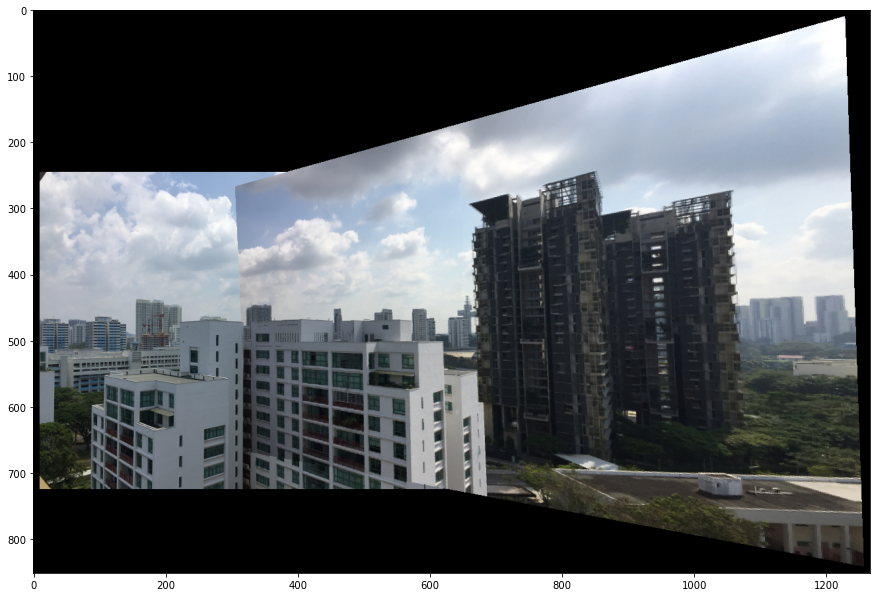

In [17]:
# Use SIFT to find keypoints and match the keypoints
[kpm,kp1,kp2] = SIFT(im1, im2)

# Using RANSAC to find best homography
# looping until best matches are done
while True:
    HH,match_best = homo_ransac(kp1,kp2,kpm,100000)
    
    if len(match_best) > 0:
        break
        
# recalculate H matrix with all inliers
H_best,_,_ = HHmat(kp1,kp2,match_best)

# im2 to im1
Hi = linalg.inv(H_best)

# get canvas and axis compensation
canvas,compensation = get_canvas(img1,img2,Hi)

# show the canvas
# print(compensation)
# plt.figure( figsize=(15,15) )
# plt.imshow(canvas)

# transfer im2 to im1 plane
img12 = trans2im1(canvas,img2,Hi,compensation,3)
img12 = img12.astype(np.uint8)

# show the sitching image
plt.figure( figsize=(15,15) )
plt.imshow(img12)
im12 = cv2.cvtColor(img12, cv2.COLOR_RGB2BGR)

### Combine im1 im2 and im3

[[ 4.80418918e+00  1.62337545e+00 -2.06889045e+03]
 [-6.26875710e-02  5.48839505e+00 -2.47769306e+03]
 [ 1.04192049e-04  6.65747780e-03  1.00000000e+00]]
[[ 5.69261687e+00 -5.31569720e-02 -2.57689819e+03]
 [ 1.69523424e+00  4.99479169e+00 -2.16032079e+03]
 [ 6.92234839e-03  1.51750069e-04  1.00000000e+00]]
[-412.8237976506183, 1425.6882726886533, 454.60635238277865, 2689.8909524688097]


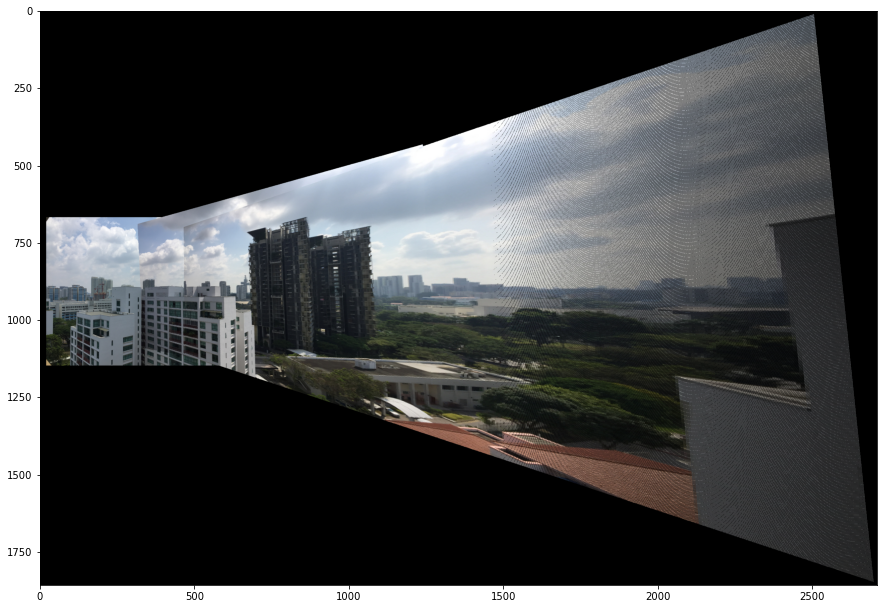

In [22]:
# Use SIFT to find keypoints and match the keypoints
[kpm,kp1,kp2] = SIFT(im12, im3)

# Using RANSAC to find best homography
# looping until best matches are done
while True:
    HH,match_best = homo_ransac(kp1,kp2,kpm,100000)
    
    if len(match_best) > 0:
        break
        
# recalculate H matrix with all inliers
H_best,_,_ = HHmat(kp1,kp2,match_best)

# im2 to im1
Hi = linalg.inv(H_best)

# get canvas and axis compensation
canvas,compensation = get_canvas(img12,img3,Hi)

# show the canvas
# print(compensation)
# plt.figure( figsize=(15,15) )
# plt.imshow(canvas)

# transfer im2 to im1 plane
img123 = trans2im1(canvas,img3,Hi,compensation,5)
img123 = img123.astype(np.uint8)

# show the sitching image
plt.figure( figsize=(15,15) )
plt.imshow(img123)
im123 = cv2.cvtColor(img123, cv2.COLOR_RGB2BGR)

### Combine im1 im2 im3 and im4

[[ 5.39690748e+00  1.82061094e+00 -4.61802723e+03]
 [-7.19146695e-02  6.16683932e+00 -2.81652913e+03]
 [ 1.12867489e-04  7.48484883e-03  1.00000000e+00]]
[[ 6.18801019e+00 -6.30559825e-02 -2.83305891e+03]
 [ 1.82701885e+00  5.42141107e+00 -4.63819617e+03]
 [ 7.51052259e-03  1.23087195e-04  1.00000000e+00]]
[8.30611517546353, 1851.383154408685, 464.8714183577038, 2704.909695462126]


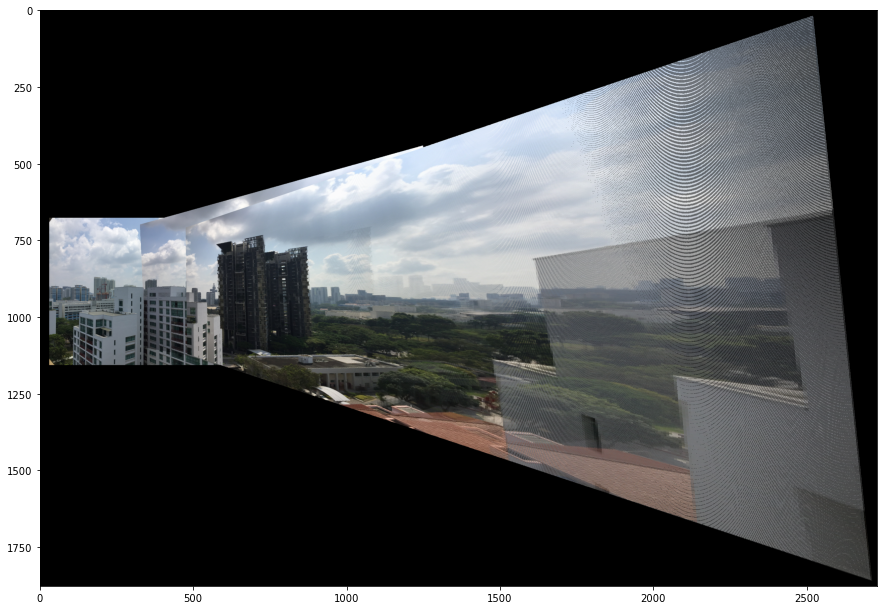

In [23]:
# Use SIFT to find keypoints and match the keypoints
[kpm,kp1,kp2] = SIFT(im123, im3)

# Using RANSAC to find best homography
# looping until best matches are done
while True:
    HH,match_best = homo_ransac(kp1,kp2,kpm,100000)
    
    if len(match_best) > 0:
        break
        
# recalculate H matrix with all inliers
H_best,_,_ = HHmat(kp1,kp2,match_best)

# im2 to im1
Hi = linalg.inv(H_best)

# get canvas and axis compensation
canvas,compensation = get_canvas(img123,img4,Hi)

# show the canvas
# print(compensation)
# plt.figure( figsize=(15,15) )
# plt.imshow(canvas)

# transfer im2 to im1 plane
img1234 = trans2im1(canvas,img4,Hi,compensation,5)
img1234 = img1234.astype(np.uint8)

# show the sitching image
plt.figure( figsize=(15,15) )
plt.imshow(img1234)
im1234 = cv2.cvtColor(img1234, cv2.COLOR_RGB2BGR)

### the im4 does not match the im123 so well

### combine im3 and im4 first

[[ 1.09339415e+00  8.92069376e-02 -5.86113815e+00]
 [-1.71690551e-02  1.22505232e+00 -1.29440955e+02]
 [-1.01142152e-04  3.93892766e-04  1.00000000e+00]]
[[ 1.22286676e+00 -1.76333821e-02 -1.29225521e+02]
 [ 8.94508257e-02  1.08842044e+00 -5.39477511e+00]
 [ 3.93507539e-04 -1.08302579e-04  1.00000000e+00]]
[-59.39749687642769, 492.5202953646327, 105.6159352382649, 793.727660397856]


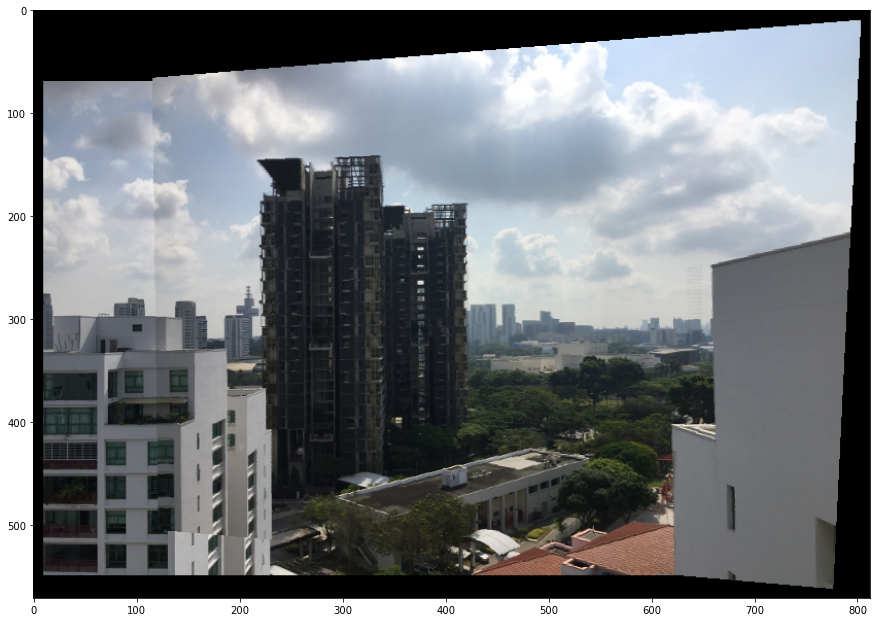

In [16]:
# Use SIFT to find keypoints and match the keypoints
[kpm,kp1,kp2] = SIFT(im3, im4)

# Using RANSAC to find best homography
# looping until best matches are done
while True:
    HH,match_best = homo_ransac(kp1,kp2,kpm,100000)
    
    if len(match_best) > 0:
        break
        
# recalculate H matrix with all inliers
H_best,_,_ = HHmat(kp1,kp2,match_best)

# im4 to im3
Hi = linalg.inv(H_best)

# get canvas and axis compensation
canvas,compensation = get_canvas(img3,img4,Hi)

# show the canvas
# print(compensation)
# plt.figure( figsize=(15,15) )
# plt.imshow(canvas)

# transfer im4 to im3 plane
img34 = trans2im1(canvas,img4,Hi,compensation,3)
img34 = img34.astype(np.uint8)

# show the sitching image
plt.figure( figsize=(15,15) )
plt.imshow(img34)
im34 = cv2.cvtColor(img34, cv2.COLOR_RGB2BGR)

### Then combine im2 with im3&4

[[ 8.31607461e-01 -1.04231414e-01 -4.66953831e+00]
 [-4.49276845e-02  6.81828816e-01  1.75406945e+02]
 [-8.67438316e-05 -4.53851478e-04  1.00000000e+00]]
[[ 6.80800919e-01 -4.45175853e-02  1.75540561e+02]
 [-1.04870703e-01  8.32617141e-01 -4.60748549e+00]
 [-4.54769846e-04 -8.54608754e-05  1.00000000e+00]]
[-26.85088782468079, 583.491014291898, -259.02879039054585, 477.11959550619713]


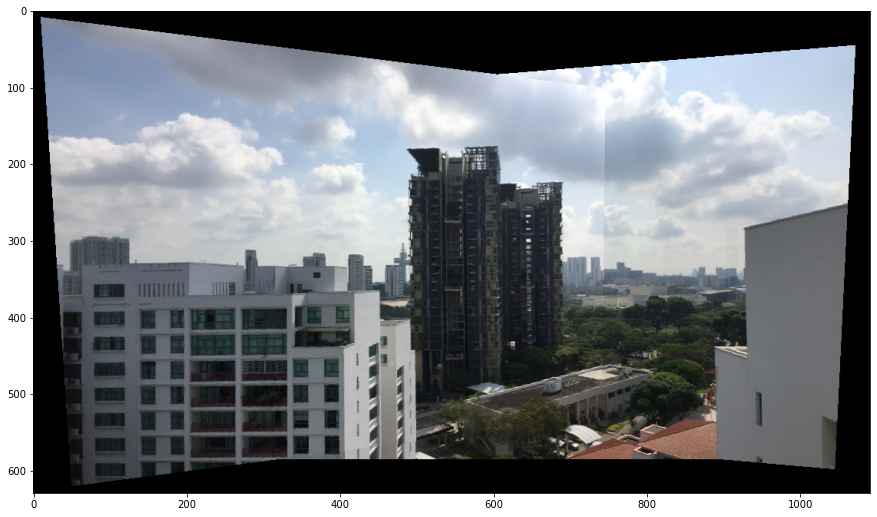

In [17]:
# Use SIFT to find keypoints and match the keypoints
[kpm,kp1,kp2] = SIFT(im34, im2)

# Using RANSAC to find best homography
# looping until best matches are done
while True:
    HH,match_best = homo_ransac(kp1,kp2,kpm,100000)
    
    if len(match_best) > 0:
        break
        
# recalculate H matrix with all inliers
H_best,_,_ = HHmat(kp1,kp2,match_best)

# im2 to im34
Hi = linalg.inv(H_best)

# get canvas and axis compensation
canvas,compensation = get_canvas(img34,img2,Hi)

# show the canvas
# print(compensation)
# plt.figure( figsize=(15,15) )
# plt.imshow(canvas)

# transfer im2 to im34 plane
img342 = trans2im1(canvas,img2,Hi,compensation,3)
img342 = img342.astype(np.uint8)

# show the sitching image
plt.figure( figsize=(15,15) )
plt.imshow(img342)
im342 = cv2.cvtColor(img342, cv2.COLOR_RGB2BGR)

### Then combine im1 with im3&4&2

[[ 6.44434044e-01 -2.25117310e-01  1.51202967e+01]
 [ 5.50346040e-03  1.37866621e-01  2.92042139e+02]
 [ 1.63119943e-05 -9.45242162e-04  1.00000000e+00]]
[[ 1.44307914e-01  2.20731840e-02  2.89869252e+02]
 [-2.27082097e-01  6.69744240e-01  9.28217971e+00]
 [-9.58780486e-04  5.90537479e-05  1.00000000e+00]]
[-752.9380491789077, 1512.592057018114, -2178.675506805269, 472.15322059659525]


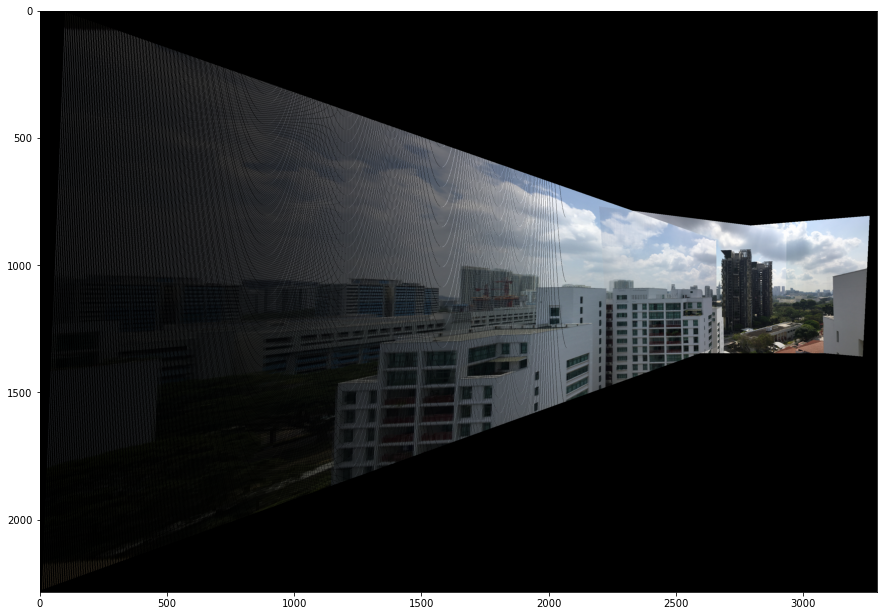

In [18]:
# Use SIFT to find keypoints and match the keypoints
[kpm,kp1,kp2] = SIFT(im342, im1)

# Using RANSAC to find best homography
# looping until best matches are done
while True:
    HH,match_best = homo_ransac(kp1,kp2,kpm,100000)
    
    if len(match_best) > 0:
        break
        
# recalculate H matrix with all inliers
H_best,_,_ = HHmat(kp1,kp2,match_best)

# im1 to im342
Hi = linalg.inv(H_best)

# get canvas and axis compensation
canvas,compensation = get_canvas(img342,img1,Hi)

# show the canvas
# print(compensation)
# plt.figure( figsize=(15,15) )
# plt.imshow(canvas)

# transfer im1 to im342 plane
img3421 = trans2im1(canvas,img1,Hi,compensation,3)
img3421 = img3421.astype(np.uint8)

# show the sitching image
plt.figure( figsize=(15,15) )
plt.imshow(img3421)
im3421 = cv2.cvtColor(img3421, cv2.COLOR_RGB2BGR)

### Finaly, add im5

[[-5.59837073e-01 -1.32346578e-01  8.76778258e+02]
 [-2.57697433e-02 -5.77635354e-01  1.64428358e+03]
 [-1.38554934e-04 -4.69299268e-04  1.00000000e+00]]
[[-5.56551674e-01 -2.36705762e-02  1.58345881e+03]
 [-1.30649395e-01 -5.33639181e-01  8.48512694e+02]
 [-4.63440116e-04 -1.33007151e-04  1.00000000e+00]]
[764.1433950326119, 1752.978165396986, 2779.935049823005, 3506.791192471176]


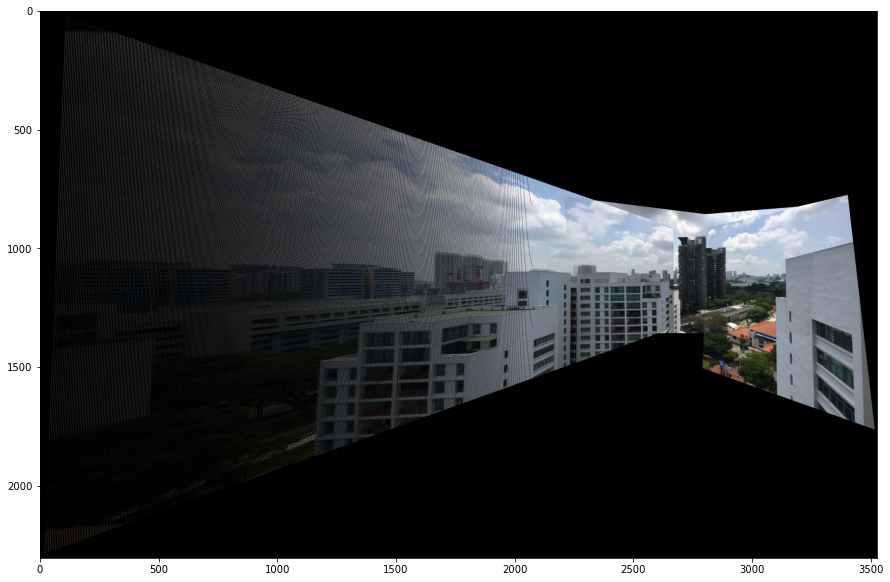

In [19]:
# Use SIFT to find keypoints and match the keypoints
[kpm,kp1,kp2] = SIFT(im3421, im5)

# Using RANSAC to find best homography
# looping until best matches are done
while True:
    HH,match_best = homo_ransac(kp1,kp2,kpm,100000)
    
    if len(match_best) > 0:
        break
        
# recalculate H matrix with all inliers
H_best,_,_ = HHmat(kp1,kp2,match_best)

# im5 to im3421
Hi = linalg.inv(H_best)

# get canvas and axis compensation
canvas,compensation = get_canvas(img3421,img5,Hi)

# show the canvas
# print(compensation)
# plt.figure( figsize=(15,15) )
# plt.imshow(canvas)

# transfer im5 to im3421 plane
img_all = trans2im1(canvas,img5,Hi,compensation,3)
img_all = img_all.astype(np.uint8)

# show the sitching image
plt.figure( figsize=(15,15) )
plt.imshow(img_all)
im_all = cv2.cvtColor(img_all, cv2.COLOR_RGB2BGR)

### clip a litte

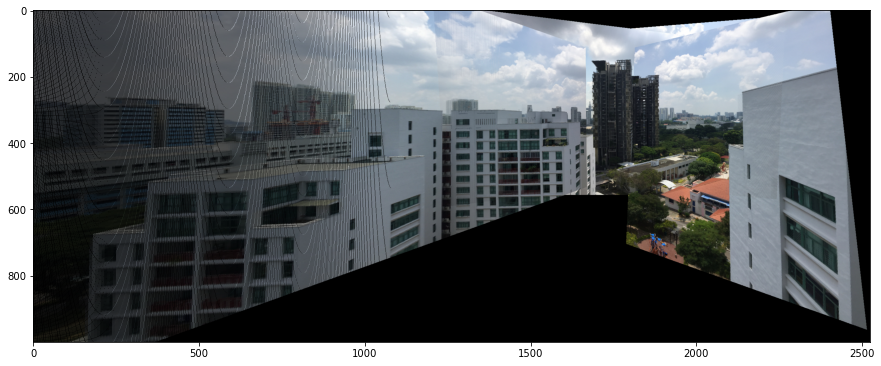

In [20]:
img_cut = img_all[800:1800,1000:,:]
# show the cliped image
plt.figure( figsize=(15,15) )
plt.imshow(img_cut)